# 1

## a
First we find $K_t$ from p. 82 of the text. Since we would prefer to use the global stress instead of net stress, we use the upper curve. $a/W$ for this chart is $0.25/7 = 0.0357$, which means $K_t = 3$.

## b
We can estimate $k_f$ using the Peterson method, with $\alpha = 0.02 \text{ in.}$ for aluminum alloys. This gives
$$q = \frac{1}{1+\alpha/\rho}$$

with the radius, $\rho=0.125 \text{ in.}$

In [60]:
import numpy as np
D = 0.25
rho = 0.25/2.0 #in.
alpha = 0.02 #in.
q = 1/(1+alpha/rho)
print q

0.862068965517


With $q = 0.862$ we can now find $k_f$

In [61]:
Kt = 3.0
kf = 1+ q*(Kt-1)
print kf

2.72413793103


$k_f = 2.72$

## c
We can now find the number of cycles to failure using a nominal stress amplitude, $S_a = k_f S$. In this case we find the stress as $S = 30/(7*0.157) = 27.3 \text{ ksi}$, which gives a nominal stress amplitude of $S_a = 74.4 \text{ ksi}$

In [62]:
P = 30.0 #k-lbs
W = 7.0
t = 0.157
S = P/(W*t)
print S
Sa = kf*S
print Sa

27.2975432211
74.3622729127


This can now be substituted into the equation for the S-N curve using data given on p. 235.
$$S_a = \sigma_f^\prime (2N_f)^b$$
Solved for $N_f$ gives
$$N_f = \frac{1}{2} \left(\frac{S_a}{\sigma_f^\prime}\right)^{1/b}$$

In [63]:
sfp = 131.0
b = -0.102
Nf = 0.5*(Sa/sfp)**(1/b)
print Nf

128.806287448


We predict 128.8 cycles to failure in this case.

# 2
First we load the given data and plot it

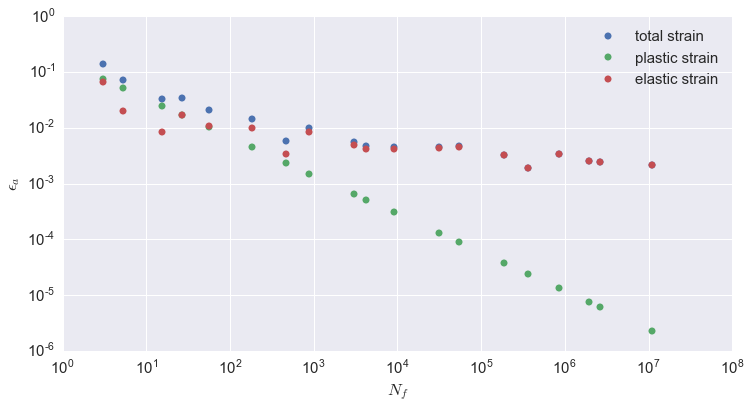

In [64]:
#load plotting libraries
from matplotlib import pyplot as plt
import seaborn as sb
sb.set(font_scale=1.5)
%matplotlib inline

data = np.loadtxt('hw7.txt')

ea = data[:,0] #total strain
epa = data[:,1] #plastic strain
eea = ea - epa #elastic strain
nf = data[:,2] #cycles to failure

plt.figure(figsize=(12,6))
plt.loglog(nf,ea,'o',label='total strain')
plt.loglog(nf,epa,'o',label='plastic strain')
plt.loglog(nf,eea,'o',label='elastic strain')
plt.legend(loc='best')
plt.xlabel('$N_f$')
plt.ylabel('$\epsilon_a$')

To find the constants, $\sigma_f^\prime$, $b$, $\epsilon_f^\prime$, and $c$ we fit linear curves (in the log-log space) the the plast and elastic strain data.

In [65]:
from scipy.optimize import curve_fit

def func(x,lsfp,b):
    return lsfp + b*x #log(sfp) + b*log(2Nf)

def func2(Nf,sfp,b):
    return sfp*(2*Nf)**b

#linear fit in log-log domain
popt,pcov = curve_fit(func,np.log10(2*nf),np.log10(epa))
efp = 10**popt[0]
c = popt[1]
popt,pcov = curve_fit(func,np.log10(2*nf),np.log10(eea))
E = 10.3e3 #ksi
sfp = 10**popt[0]*E
b = popt[1]

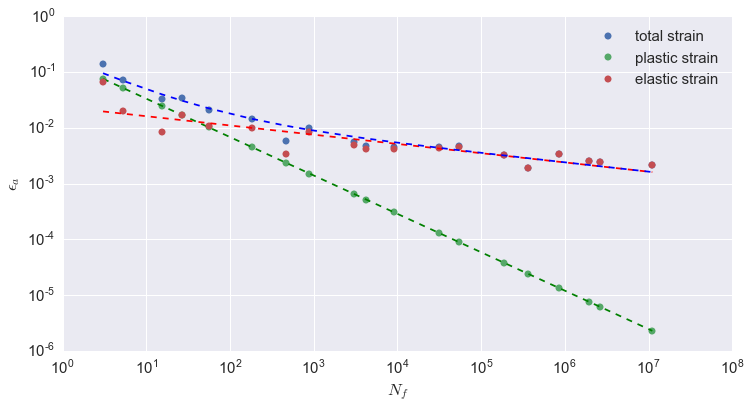

In [66]:
plt.figure(figsize=(12,6))
plt.loglog(nf,ea,'o',label='total strain')
plt.loglog(nf,epa,'o',label='plastic strain')
plt.loglog(nf,func2(nf,efp,c),'g--')
plt.loglog(nf,eea,'o',label='elastic strain')
plt.loglog(nf,func2(nf,sfp/E,b),'r--')
plt.loglog(nf,func2(nf,sfp/E,b)+func2(nf,efp,c),'b--')
plt.legend(loc='best')
plt.xlabel('$N_f$')
plt.ylabel('$\epsilon_a$')

We see a good fit, so we now examine the constants

In [67]:
print sfp, b, efp, c

273.692934459 -0.165634191231 0.262092470055 -0.688091438879


And we find $\sigma_f^\prime = 273.7 \text{ ksi}$, $b = -0.166$, $\epsilon_f^\prime = 0.262$ and $c=-0.688$.

# 3

We can find the transition life, $N_t$ by finding the point of intersection between the plastic strain and elastic strain curves. Visually, we would expect it to occur near 20 cycles, but we can solve for it directly.

In [68]:
Nt = 0.5*(sfp/efp/E)**(1/(c-b))
print Nt

39.9550761435


And we find $N_t = 40$

# 4

For the Morrow approach we use
$$\epsilon_a = \frac{\sigma_f^\prime}{E}\left(1-\frac{\sigma_m}{\sigma_f^\prime}\right) (2N_f)^b + \epsilon_f^\prime \left(1-\frac{\sigma_m}{\sigma_f^\prime}\right)^{c/b} (2N_f)^c$$

For the modified Morrow approach, we use the same equation but only adjust the elastic portion
$$\epsilon_a = \frac{\sigma_f^\prime}{E}\left(1-\frac{\sigma_m}{\sigma_f^\prime}\right) (2N_f)^b + \epsilon_f^\prime (2N_f)^c$$

And finally, in the Smith, Watson and Topper approach we use
$$\epsilon_a = \frac{1}{\sigma_{max}} \left[\frac{\left(\sigma_f^\prime\right)^2}{E}(2N_f)^{2b} + \sigma_f^\prime \epsilon_f^\prime (2N_f)^{b+c}\right]$$

To find $\sigma_{max}$, we add $\sigma_m$ to the stress amplitude, $\sigma_a$. $\sigma_a$ can be found using the stress-strain curve.
$$\epsilon_a = \frac{\sigma_a}{E} + \left(\frac{\sigma_a}{H^\prime}\right)^{1/n^\prime}$$

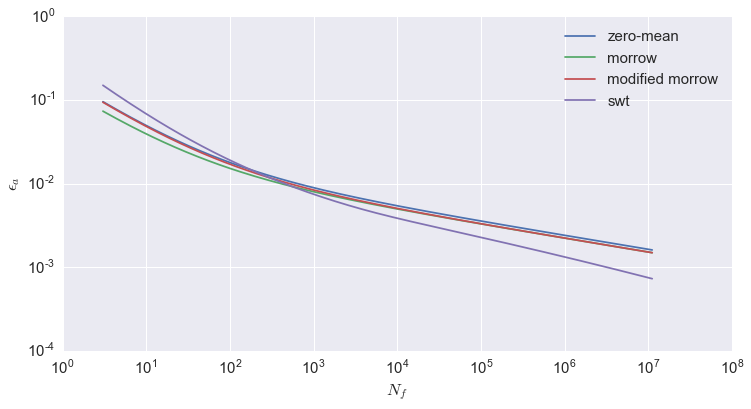

In [69]:
sm = 20.0 #ksi, mean stress
Nf = np.logspace(np.log10(min(nf)),np.log10(max(nf)),200)
ea_morrow = sfp/E*(1-sm/sfp)*(2*Nf)**b + efp*(1-sm/sfp)**(c/b)*(2*Nf)**c
ea_mod = sfp/E*(1-sm/sfp)*(2*Nf)**b + efp*(2*Nf)**c
#numerical solver
from scipy.optimize import fsolve
Hp = 142.0
n = 0.106
ea_smooth = func2(Nf,sfp/E,b)+func2(Nf,efp,c)
swt = lambda sa: -ea_smooth + sa/E + (sa/Hp)**(1/n)
sa = fsolve(swt,func2(Nf,sfp,b))
smax = sm + sa
ea_swt = (sfp**2/E*(2*Nf)**(2*b)+sfp*efp*(2*Nf)**(b+c))/smax
plt.figure(figsize=(12,6))
plt.loglog(Nf,ea_smooth,label='zero-mean')
plt.loglog(Nf,ea_morrow,label='morrow')
plt.loglog(Nf,ea_mod,label='modified morrow')
plt.loglog(Nf,ea_swt,label='swt')
plt.xlabel('$N_f$')
plt.ylabel('$\epsilon_a$')
plt.legend(loc='best')

From these we see that the modified Morrow equation matches the zero-mean data nearly exactly at low-cycles, and converges to the morrow method for higher cycles, the Morrow method itself is almost uniformly lower than the zero-mean data, while the SWT shows a different trend, with an increase in life before the transition region, and a stronger decrease after. Without test data we cannot comment on which is the best fit, but they do provide different estimates.